<br><br>
<font size='6'><b>Generative Adversarial Networks (GAN)</b></font><br><br>

<br>
<div class=pull-right>
By Prof. Seungchul Lee<br>
http://iai.postech.ac.kr/<br>
Industrial AI Lab at POSTECH
</div>

Table of Contents
<div id="toc"></div>

# 1. Discriminative Model v.s. Generative Model

- Discriminative model

<br><br>
<center><img src="./image_files/discriminative.png" width = 450></center>
<br>


- Cenerative model

<br>
<center><img src="./image_files/generative.png" width = 460></center>
<br>


# 2. Density Function Estimation


- Probability density function estimation problem


<center><img src="./image_files/dist.png" width = 500></center>

<center><img src="./image_files/estimation.png" width = 600></center>


- If $P_{\text{model}}(x)$ can be estimated as close to $P_{\text{data}}(x)$, then data can be generated by sampling from $P_{\text{model}}(x)$.

    - Note: Kullback–Leibler Divergence is a kind of distance measure between two distributions


- Learn determinstic transformation via a neural network
    - Start by sampling the code vector $z$ from a simple, fixed distribution such as a uniform distribution or a standard Gaussian $\mathcal{N}(0,I)$
    - Then this code vector is passed as input to a deterministic generator network $G$, which produces an output sample $x=G(z)$
    - This is how a neural network plays in a generative model (as a nonlinear mapping to a target probability density function)

<br>
<center><img src="./image_files/latent2x.png" width = 400></center>
<br>


- An example of a generator network which encodes a univariate distribution with two different modes

<br><br>
<center><img src="./image_files/density_transformation.png" width = 500></center>

- Generative model of high dimensional space

<center><img src="./image_files/latent2highDim.png" width = 600></center>


# 3. Generative Adversarial Networks (GAN)

- In generative modeling, we'd like to train a network that models a distribution, such as a distribution over images.

- GANs do not work with any explicit density function !

- Instead, take game-theoretic approach


- One way to judge the quality of the model is to sample from it.
    
- Model to produce samples which are indistinguishable from the real data, as judged by a discriminator network whose job is to tell real from fake


<br><br>
<center><img src="./image_files/turingtest.png" width = 300></center>
<br>

<br>
<center><img src="./image_files/my_GAN.png" width = 500></center>
<br>


- The idea behind Generative Adversarial Networks (GANs): train two different networks

<br>
<center><img src="./image_files/intuitionGAN_01.png" width = 700></center>        
<ve>

- Discriminator network: try to distinguish between real and fake data

<br>
<center><img src="./image_files/intuitionGAN_02.png" width = 700></center>
<ve>

<center><img src="./image_files/intuitionGAN_03.png" width = 700></center>
<br>

- Generator network: try to produce realistic-looking samples to fool the discriminator network

<br>
<center><img src="./image_files/intuitionGAN_04.png" width = 700></center>   


# 4. GAN with MNIST

## 4.1. GAN Implementation

In [1]:
!nvidia-smi

Wed Apr 28 12:50:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0  On |                  N/A |
| 31%   48C    P8    12W / 250W |  11126MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 38%   48C    P8    11W / 250W |    284MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [5]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), _ = mnist.load_data()
train_x = train_x[np.where(train_y == 2)]
train_x= train_x/255.0
train_x = train_x.reshape(-1, 784)
print('train_iamges :', train_x.shape)

train_iamges : (5958, 784)


<center><img src="./image_files/GAN_structure.png" width = 300></center>

In [6]:
'''
generator = tf.keras.models.Sequential
'''
generator = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = (100)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(784, activation = 'sigmoid'),
        ])

In [7]:
'''
discriminator = tf.keras.models.Sequential
'''
discriminator = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = (784)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])

In [8]:
'''
discriminator.compile

optimizer = tf.keras.optimizers.Adam
learning_rate = 0.0001
loss = binary_crossentropy
'''
discriminator.compile(tf.keras.optimizers.Adam(learning_rate = 0.0001),
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy']
                     )

In [9]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


In [10]:
'''
combined model

1. gaussian noise input --> tf.keras.layers.Input(shape = (100,))
2. gaussian noise가 generator를 거쳐 generated data 만들기
3. discriminator의 weight update False --> (hint: discriminator.trainable)
4. generated data가 discriminator를 거친 output
5. 위에 code들을 keras.model로 형성 --> (hint: tf.keras.models.Model(inputs = ?, outputs = ?))
'''

combined_input = tf.keras.layers.Input(shape = (100,))
generated = generator(combined_input)
discriminator.trainable = False
combined_output = discriminator(generated)

combined = tf.keras.models.Model(inputs = combined_input, outputs = combined_output)

In [11]:
'''
combined model.compile

optimizer = tf.keras.optimizers.Adam
learning_rate = 0.0002 # discriminator가 성능이 더 좋기 때문에 learniing rate를 다르게 가져감
loss = binary_crossentropy
'''
combined.compile(tf.keras.optimizers.Adam(learning_rate = 0.0002),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy']
                )

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 201,217
Trainable params: 0
Non-trainable params: 201,217
_________________________________________________________________


In [13]:
def make_noise(samples):
    return np.random.normal(0, 1, [samples, 100]) # normal = 가우시안 분포

In [14]:
def plot_generated_images(generator, samples = 3):
    
    noise = make_noise(samples)
    
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(samples, 28, 28)
    
    for i in range(samples):
        plt.subplot(1, samples, i+1)
        plt.imshow(generated_images[i], 'gray', interpolation = 'nearest')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

Discriminator Loss:  [0.7689851522445679, 0.3199999928474426, 0.7645170092582703, 0.10999999940395355]
Generator Loss:  [0.7516291737556458, 0.11999999731779099]


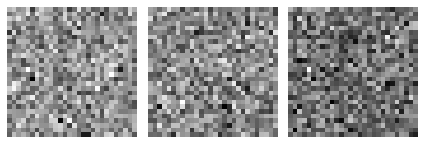

Discriminator Loss:  [0.07640794664621353, 1.0, 0.08845628052949905, 1.0]
Generator Loss:  [2.681317090988159, 0.0]


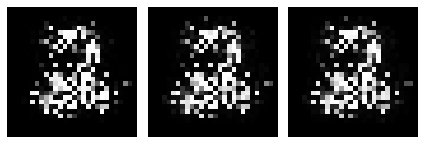

Discriminator Loss:  [0.10004512965679169, 0.9800000190734863, 0.12432517856359482, 1.0]
Generator Loss:  [2.507349967956543, 0.0]


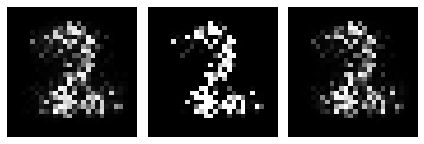

Discriminator Loss:  [0.20121340453624725, 0.9100000262260437, 0.24978598952293396, 0.9599999785423279]
Generator Loss:  [1.8697655200958252, 0.019999999552965164]


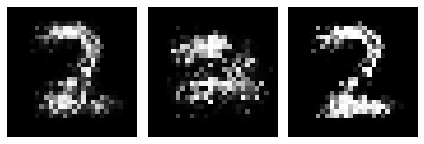

Discriminator Loss:  [0.32515379786491394, 0.8700000047683716, 0.21305739879608154, 0.949999988079071]
Generator Loss:  [1.9782360792160034, 0.07000000029802322]


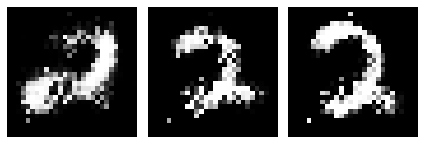

Discriminator Loss:  [0.28204941749572754, 0.8899999856948853, 0.23911021649837494, 0.9800000190734863]
Generator Loss:  [1.9878137111663818, 0.009999999776482582]


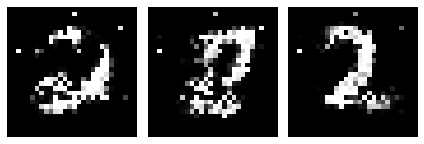

Discriminator Loss:  [0.3272753059864044, 0.8399999737739563, 0.3065681755542755, 0.9599999785423279]
Generator Loss:  [1.5939422845840454, 0.05000000074505806]


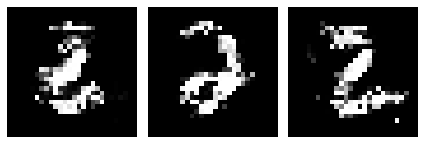

Discriminator Loss:  [0.3144737482070923, 0.8799999952316284, 0.29749342799186707, 0.9200000166893005]
Generator Loss:  [1.8436909914016724, 0.10999999940395355]


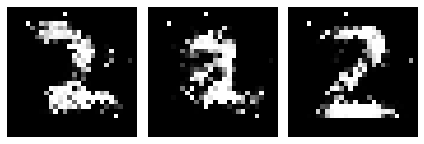

Discriminator Loss:  [0.3450257182121277, 0.8399999737739563, 0.4321587383747101, 0.8500000238418579]
Generator Loss:  [1.5153801441192627, 0.07999999821186066]


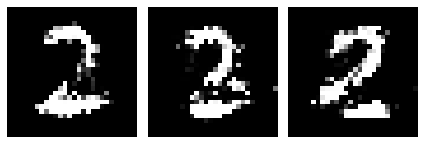

Discriminator Loss:  [0.2526414096355438, 0.9200000166893005, 0.20273533463478088, 0.9599999785423279]
Generator Loss:  [2.404709577560425, 0.019999999552965164]


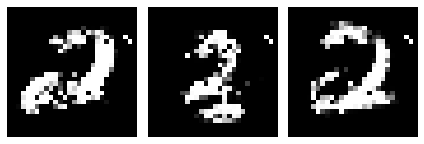

In [15]:
n_iter = 20000
batch_size = 100

fake = np.zeros(batch_size) #fake는 0
real = np.ones(batch_size) #real은 1

for i in range(n_iter): # 학습을 20000번 돌 예정
    
    # Train Discriminator
    '''
    noise를 이용해 data generation
    1. batch_size만큼 noise input
    2. generator모델을 거쳐 generated_images 제작
    
    3. real data에 대해 noise와 같은 갯수의 batch 제작
    
    4. D_loss_real 설정하기 discriminator.train_on_batch(real_images, real)
    5. D_loss_fake 설정하기 discriminator.train_on_batch(geneerated_images, fake)
    6. D_total_loss = D_loss_real + D_loss_fake
    '''
    #100개의 fake 이미지
    noise = make_noise(batch_size)
    generated_images = generator.predict(noise)

    #100개의 freal 이미지    
    idx = np.random.randint(0, train_x.shape[0], batch_size) # 0부터 10000사이의 100개의 랜덤 정수를 뽑아내는 것을 idx로 받아옴
    real_images = train_x[idx] # 100개만큼의 랜덤 배치 생성

    # fake와 real로 학습
    # fit과 마지막 output의 표현방식이 조금다름
    # discriminator.train_on_batch(real_images, real) : discriminator 학습하고자하는모델, real_images input, real 나왔으면 하는 output
    # train_on_batch(), 괄호안의 batch에 대해 학습 fit과 거의 유사
    
    D_loss_real = discriminator.train_on_batch(real_images, real) # real이미지에 대한 loss
    D_loss_fake = discriminator.train_on_batch(generated_images, fake) # fake와이미지에 대한 loss
    D_loss = D_loss_real + D_loss_fake
    
    # Train Generator
    '''
    1. batch_size만큼 noise generation
    2. G_loss 설정하기 combined.train_on_batch(noise, real)
    '''
    noise = make_noise(batch_size)    
    G_loss = combined.train_on_batch(noise, real)
    
    if i % 2000 == 0:
        
        print('Discriminator Loss: ', D_loss)
        print('Generator Loss: ', G_loss)

        plot_generated_images(generator)

## 4.2. After Training


- After training, use the generator network to generate new data


<center><img src="./image_files/GAN_done.png" width = 600></center>
<br>


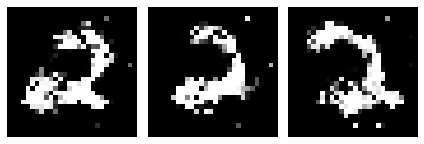

In [16]:
'''
Training 후 data generation
'''
plot_generated_images(generator)

In [31]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>